In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle_zillow
from env import get_db_url
from matplotlib import style
style.use('ggplot')


In [2]:
# this will be transfered to acquire.py
# get_zillow_data while maintaining my original query from previous project
def get_zillow_data2(use_cache=True):
    """Same as above but pulls in more squarefoot data, pull from SQL unless zillow.csv exists"""
    filename = "zillow2.csv"
    if os.path.isfile(filename) and use_cache:
        print("Reading from csv...")
        return pd.read_csv(filename)

    print("reading from sql...")
    url = get_db_url("zillow")
    query = """
        SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 

FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
"""

    df = pd.read_sql(query, url)

    print("Saving to csv in local directory...")
    df.to_csv(filename, index=False)
    return df

In [3]:
df = wrangle_zillow.get_zillow_data()

Reading from csv...


/var/folders/f5/w0p7b4_j2kdg3kvlsz7nhtn40000gn/T/ipykernel_5085/2136395875.py:1: DtypeWarning: Columns (63) have mixed types.Specify dtype option on import or set low_memory=False.
  df = wrangle_zillow.get_zillow_data()


In [4]:
#count number of rows where parcelid is duplicated
df.parcelid.duplicated().sum()

193

In [5]:
# drop duplicate parcelid
# df = df.drop_duplicates(subset='parcelid')
df = wrangle_zillow.clear_parcel_id_duplicates(df)

In [6]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [7]:
df.shape

(77381, 68)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77381 non-null  int64  
 1   parcelid                      77381 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77381 non-null  float64
 6   bedroomcnt                    77381 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49672 non-null  float64
 9   calculatedbathnbr             76772 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77185 non-null  float64
 13  f

In [9]:
# move to prepare.py or explore.py
# return a df with number of missing values for each column and the percentage of missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [10]:
wrangle_zillow.missing_values_table(df)

Your selected dataframe has 68 columns.
There are 52 columns that have missing values.


,Missing Values,% of Total Values
buildingclasstypeid,77366,100.0
buildingclassdesc,77366,100.0
finishedsquarefeet13,77340,99.9
basementsqft,77331,99.9
storydesc,77331,99.9
storytypeid,77331,99.9
yardbuildingsqft26,77311,99.9
fireplaceflag,77209,99.8
architecturalstyledesc,77175,99.7
architecturalstyletypeid,77175,99.7


In [11]:
# move to prepare.py or explore.py
# return a df with number of missing columns and the percentage of missing values
def missing_columns_table(df):
    df2 = pd.DataFrame(df.isnull().sum(axis=1), columns=['num_cols_missing']).reset_index()
    # groupby num_cols_missing and count the number of rows with the same num_cols_missing
    df2 = df2.groupby('num_cols_missing').count().reset_index()
    # rename index to num_rows
    df2 = df2.rename(columns={'index': 'num_rows'})
    # add column with percentage of missing values
    df2['percent_missing'] = (100 * df2['num_cols_missing'] / df.shape[1]).round(1)
    return df2.sort_values('num_cols_missing', ascending=False)
    
wrangle_zillow.missing_columns_table(df)



,num_cols_missing,num_rows,percent_missing
25,48,3,70.6
24,47,3,69.1
23,46,5,67.6
22,45,50,66.2
21,44,78,64.7
20,43,28,63.2
19,42,23,61.8
18,41,29,60.3
17,40,230,58.8
16,39,285,57.4


In [12]:
df[(df['unitcnt'] <2)|(df['unitcnt'].isnull())]['unitcnt'].value_counts(dropna=False)

1.0    47293
NaN    26818
Name: unitcnt, dtype: int64

In [13]:
df.shape

(77381, 68)

In [14]:
def get_single_units(df):
    """returns a df with only single units"""
    # list of property types that are likely single unit
    likely_single_unit =  [261, 262, 263, 264, 265, 266, 268, 273, 275, 276, 279]
    #keep only single unit properties by property type
    temp_df = df[df.propertylandusetypeid.isin(likely_single_unit)]
    # keep only single unit properties by unitcnt ignoring null
    return temp_df[(temp_df['unitcnt'] <2) | (temp_df['unitcnt'].isnull())]

wrangle_zillow.get_single_units(df)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,2864704,10833991,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037132e+13,-0.002245,2017-09-20,Central,NaN,NaN,Central,Condominium,NaN,NaN
77570,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77571,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,6.111008e+13,0.013209,2017-09-21,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
77572,1843709,12773139,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,6.037434e+13,0.037129,2017-09-21,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [15]:
# differnce in rows between single_units and df
df.shape[0] - get_single_units(df).shape[0], df.shape[1] - get_single_units(df).shape[1]


(5332, 0)

In [16]:
# lets update df to have only single units
df = wrangle_zillow.get_single_units(df)
df.shape

(72049, 68)

In [17]:
def handle_missing_values(df,prop_required_col, prop_required_row):
    """drop column/row if it has more than prop_required_row missing values or more than prop_required_col missing values"""
    df2=df.copy()
    threshold = int(round(prop_required_col*len(df2.index),0))
    df2.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df2.columns),0))
    df2.dropna(axis=0, thresh=threshold, inplace=True)
    return df2


In [18]:
df3=wrangle_zillow.handle_missing_values(df, 0.7, 0.7)
df3

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,1727539,14297519,3.5,4.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,1970746,10887214,3.0,3.0,3.0,1312.0,1312.0,6037.0,3.0,34185120.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,2864704,10833991,3.0,3.0,3.0,1741.0,1741.0,6037.0,3.0,34202400.0,...,1980.0,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,Condominium
77570,673515,11000655,2.0,2.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,...,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Single Family Residential
77571,2968375,17239384,2.0,4.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,Single Family Residential
77572,1843709,12773139,1.0,3.0,1.0,1032.0,1032.0,6037.0,1.0,34040895.0,...,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Single Family Residential


In [19]:
df3.shape

(72047, 29)

In [20]:
# differnce in size between original df and df with missing values removed
df.shape[0] - df3.shape[0], df.shape[1] - df3.shape[1]


(2, 39)

In [21]:
wrangle_zillow.missing_values_table(df3)

Your selected dataframe has 29 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
lotsizesquarefeet,8131,11.3
regionidcity,1333,1.9
finishedsquarefeet12,377,0.5
calculatedbathnbr,241,0.3
fullbathcnt,241,0.3
censustractandblock,220,0.3
yearbuilt,193,0.3
calculatedfinishedsquarefeet,160,0.2
structuretaxvaluedollarcnt,96,0.1
regionidzip,43,0.1


In [22]:
# look and see the bathroom counts by column name to get an idea how to fill nulls
df3[['bathroomcnt','calculatedbathnbr','fullbathcnt']]

,bathroomcnt,calculatedbathnbr,fullbathcnt
0,3.5,3.5,3.0
1,1.0,1.0,1.0
2,2.0,2.0,2.0
3,3.0,3.0,3.0
4,3.0,3.0,3.0
...,...,...,...
77569,3.0,3.0,3.0
77570,2.0,2.0,2.0
77571,2.0,2.0,2.0
77572,1.0,1.0,1.0


In [23]:
df3.censustractandblock.value_counts()

6.037137e+13    60
6.037277e+13    51
6.059032e+13    44
6.059063e+13    41
6.059063e+13    40
                ..
6.037144e+13     1
6.037263e+13     1
6.059099e+13     1
6.037461e+13     1
6.037503e+13     1
Name: censustractandblock, Length: 36345, dtype: int64

In [24]:
list_to_fill = missing_values_table(df3).index.tolist()
# make strings to assist in commenting and writing code
for feature in list_to_fill:
    print(f"fill missing values in {feature}")

Your selected dataframe has 29 columns.
There are 13 columns that have missing values.
fill missing values in lotsizesquarefeet
fill missing values in regionidcity
fill missing values in finishedsquarefeet12
fill missing values in calculatedbathnbr
fill missing values in fullbathcnt
fill missing values in censustractandblock
fill missing values in yearbuilt
fill missing values in calculatedfinishedsquarefeet
fill missing values in structuretaxvaluedollarcnt
fill missing values in regionidzip
fill missing values in taxamount
fill missing values in landtaxvaluedollarcnt
fill missing values in taxvaluedollarcnt


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

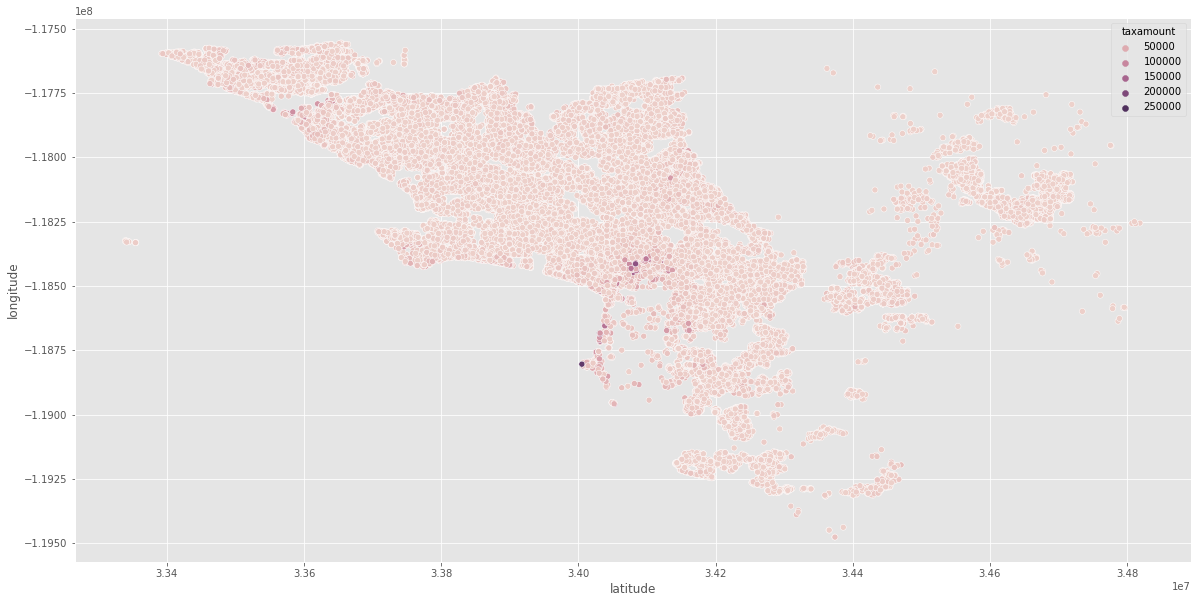

In [25]:
# make a graph to look at options to fill data
#increase figure size
plt.figure(figsize=(20,10))
sns.scatterplot(data=df3, x='latitude', y='longitude', hue='taxamount')

In [26]:
# # drop rows where yearbuilt is null
# df3.dropna(subset=['yearbuilt'], inplace=True)
# # drop rows where regionidzip is null
# df3 = df3[df3.regionidzip.notnull()] # remove the 43 out of 72407 rows
# # fill missing values in lotsizesquarefeet with median for same regionidzip and yearbuilt
# df3['lotsizesquarefeet'] = df3.groupby(['regionidzip', 'yearbuilt'])['lotsizesquarefeet'].transform(lambda x: x.fillna(x.median()))
# # fill missing values in regionidcity with median for same regionidzip and yearbuilt
# df3['regionidcity'] = df3.groupby(['regionidzip', 'yearbuilt'])['regionidcity'].transform(lambda x: x.fillna(x.median()))
# # fill missing values in finishedsquarefeet12 with median for same regionidzip and yearbuilt
# df3['finishedsquarefeet12'] = df3.groupby(['regionidzip', 'yearbuilt'])['finishedsquarefeet12'].transform(lambda x: x.fillna(x.median()))
# # fill missing values in calculatedbathnbr with bathroomcnt
# df3['calculatedbathnbr'].fillna(df3['bathroomcnt'], inplace=True)
# # fill missing values in fullbathcnt from bathroomcnt as int
# df3['fullbathcnt'].fillna(df3['bathroomcnt'].astype(int), inplace=True)
# # drop the remaining null values
# df3.dropna(inplace=True)
df3= wrangle_zillow.drop_replace_nulls(df3)



/Users/teceno/codeup-data-science/clustering-exercises/wrangle_zillow.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lotsizesquarefeet"] = df.groupby(["regionidzip", "yearbuilt"])[
/Users/teceno/codeup-data-science/clustering-exercises/wrangle_zillow.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["regionidcity"] = df.groupby(["regionidzip", "yearbuilt"])[
/Users/teceno/codeup-data-science/clustering-exercises/wrangle_zillow.py:132: SettingWithCopyWarning: 
A value is trying to be set on

In [27]:
df3.sample(10)

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
76770,454021,12198336,1.0,3.0,1.0,1216.0,1216.0,6037.0,1.0,33967698.0,...,1927.0,61000.0,299000.0,2016.0,238000.0,3730.72,6.037240e+13,0.159043,2017-09-15,Single Family Residential
29131,2776194,11086855,3.0,3.0,3.0,1488.0,1488.0,6037.0,3.0,34250700.0,...,1981.0,148666.0,286590.0,2016.0,137924.0,3552.23,6.037113e+13,0.000801,2017-04-24,Condominium
145,699617,14753715,2.5,3.0,2.5,1538.0,1538.0,6059.0,2.0,33557290.0,...,1990.0,181548.0,515844.0,2016.0,334296.0,5186.72,6.059063e+13,-0.011283,2017-01-03,Condominium
42549,678156,12299647,1.0,2.0,1.0,1175.0,1175.0,6037.0,1.0,33947389.0,...,1929.0,58568.0,206900.0,2016.0,148332.0,2845.11,6.037536e+13,0.034863,2017-06-01,Single Family Residential
42920,352735,12968839,2.0,3.0,2.0,1290.0,1290.0,6037.0,2.0,34150257.0,...,1953.0,409000.0,986827.0,2016.0,577827.0,12815.01,6.037431e+13,-0.055745,2017-06-02,Single Family Residential
3301,1100015,14091518,2.0,4.0,2.0,1276.0,1276.0,6059.0,2.0,33768849.0,...,1958.0,69674.0,220145.0,2016.0,150471.0,2928.26,6.059100e+13,0.118509,2017-01-17,Single Family Residential
57668,1930115,12078817,3.0,2.0,3.0,1701.0,1701.0,6037.0,3.0,34167449.0,...,1990.0,184738.0,579897.0,2016.0,395159.0,6330.43,6.037301e+13,-0.047491,2017-07-17,Single Family Residential
49880,1020039,12059342,1.0,1.0,1.0,701.0,701.0,6037.0,1.0,34164600.0,...,1957.0,69240.0,108183.0,2016.0,38943.0,1161.32,6.037301e+13,0.063031,2017-06-23,Condominium
1062,908881,11153699,3.0,4.0,3.0,2420.0,2420.0,6037.0,3.0,34395791.0,...,2004.0,296148.0,522853.0,2016.0,226705.0,6824.12,6.037920e+13,0.037418,2017-01-05,Single Family Residential
19910,1789056,12253182,3.0,4.0,3.0,1914.0,1914.0,6037.0,3.0,33899849.0,...,2003.0,183754.0,423957.0,2016.0,240203.0,5321.25,6.037291e+13,-0.021308,2017-03-24,Single Family Residential


In [28]:
wrangle_zillow.missing_columns_table(df3)

,num_cols_missing,num_rows,percent_missing
0,0,68536,0.0


In [29]:
wrangle_zillow.missing_values_table(df3)

Your selected dataframe has 29 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [30]:
#looking at columns with repeated you useless information
columns_to_drop = ['id', 'calculatedbathnbr','calculatedbathnbr','finishedsquarefeet12', 'fullbathcnt']

In [31]:
df3= df3.drop(columns_to_drop, axis=1)
df3

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,010C,266.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77569,10833991,3.0,3.0,1741.0,6037.0,34202400.0,-118502000.0,59487.0,010C,266.0,...,1980.0,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,Condominium
77570,11000655,2.0,2.0,1286.0,6037.0,34245368.0,-118282383.0,47405.0,0100,261.0,...,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Single Family Residential
77571,17239384,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,12105.0,1111,261.0,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,Single Family Residential
77572,12773139,1.0,3.0,1032.0,6037.0,34040895.0,-118038169.0,5074.0,0100,261.0,...,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,2017-09-21,Single Family Residential


In [32]:
df3.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,122,261.0,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1110,261.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,122,261.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,0101,261.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,010C,266.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,Condominium


In [33]:
df3.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'logerror', 'transactiondate',
       'propertylandusedesc'],
      dtype='object')

In [35]:
df3.propertylandusedesc.value_counts()

Single Family Residential                     51446
Condominium                                   16662
Cluster Home                                    332
Mobile Home                                      60
Manufactured, Modular, Prefabricated Homes       32
Townhouse                                         4
Name: propertylandusedesc, dtype: int64